In [0]:
from keras.datasets import cifar10
from keras.models import model_from_json
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.misc 

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
# Preprocessing: 
# 1. Create augmentation of the dataset
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=15,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True, featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_test)
# 2. Create new label set with 0 = alive, 1 = dead

def mapping(class_index):
    return {
        0: 1, #airplane
        1: 1, #automobile
        2: 0, #bird
        3: 0, #cat
        4: 0, #deer
        5: 0, #dog
        6: 0, #frog
        7: 0, #horse
        8: 1, #ship
        9: 1, #truck
    }[class_index]

vmap = np.vectorize(mapping)
y_train_dead_alive = vmap(y_train)
y_test_dead_alive = vmap(y_test)

Image is dead?  [0]


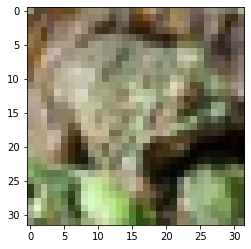

In [4]:
# Sample showing some of the data:

def show_img(index):
    plt.imshow(test_datagen.random_transform(x_train[index]))
    # show the plot
    plt.show()


index = random.randint(1, x_train.shape[0])
print("Image is dead? ", y_train_dead_alive[index])
show_img(index)

In [23]:
# Network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (7,7), kernel_initializer=tf.keras.initializers.he_normal(seed=None), kernel_regularizer=tf.keras.regularizers.l2(0.01), strides=2, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), kernel_initializer=tf.keras.initializers.he_normal(seed=None), kernel_regularizer=tf.keras.regularizers.l2(0.01), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=tf.keras.initializers.he_normal(seed=None), kernel_regularizer=tf.keras.regularizers.l2(0.01), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=tf.keras.initializers.he_normal(seed=None), kernel_regularizer=tf.keras.regularizers.l2(0.01), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
    
    tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=tf.keras.initializers.he_normal(seed=None), kernel_regularizer=tf.keras.regularizers.l2(0.01), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=tf.keras.initializers.he_normal(seed=None), kernel_regularizer=tf.keras.regularizers.l2(0.01), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.5),
    
   # flatten the last layer to an arbitray number (bathc size) of 1-d units
    tf.keras.layers.Flatten(),

    # declare a dense layer with 64 units and ReLU activation function
    tf.keras.layers.Dense(64, kernel_initializer=tf.keras.initializers.he_normal(seed=None), kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),

    # declare a dense layer with sigmoid classifier to get binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])


def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 25:
        lrate = 0.0005
    if epoch > 40:
        lrate = 0.0001
    if epoch > 50:
        lrate = 0.00005        
    return lrate

model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

batch_size = 32
model.fit_generator(datagen.flow(x_train, y_train_dead_alive, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=65, 
                    validation_data=test_datagen.flow(x_test,y_test_dead_alive), callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)], verbose=2)

#testing
scores = model.evaluate(test_datagen.standardize(x_test.astype(float)), y_test_dead_alive, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Epoch 1/65
Epoch 1/65
1562/1562 - 35s - loss: 2.5376 - acc: 0.8143 - val_loss: 0.4725 - val_acc: 0.8693
Epoch 2/65
Epoch 1/65
1562/1562 - 31s - loss: 0.4420 - acc: 0.8663 - val_loss: 0.4353 - val_acc: 0.8587
Epoch 3/65
Epoch 1/65
1562/1562 - 31s - loss: 0.4299 - acc: 0.8625 - val_loss: 0.5349 - val_acc: 0.8398
Epoch 4/65
Epoch 1/65
1562/1562 - 31s - loss: 0.4278 - acc: 0.8689 - val_loss: 0.3905 - val_acc: 0.8801
Epoch 5/65
Epoch 1/65
1562/1562 - 31s - loss: 0.4225 - acc: 0.8683 - val_loss: 0.3843 - val_acc: 0.8871
Epoch 6/65
Epoch 1/65
1562/1562 - 30s - loss: 0.4172 - acc: 0.8707 - val_loss: 0.4196 - val_acc: 0.8692
Epoch 7/65
Epoch 1/65
1562/1562 - 30s - loss: 0.4065 - acc: 0.8705 - val_loss: 0.4099 - val_acc: 0.8895
Epoch 8/65
Epoch 1/65
1562/1562 - 31s - loss: 0.3934 - acc: 0.8753 - val_loss: 0.4063 - val_acc: 0.8766
Epoch 9/65
Epoch 1/65
1562/1562 - 31s - loss: 0.3820 - acc: 0.8772 - val_loss: 0.3297 - val_acc: 0.9002
Epoch 10/65
Epoch 1/65
1562/1562 - 30s - loss: 0.3710 - acc: 0.8

Image is dead?  [1]
Prediction:  [0.8610327]


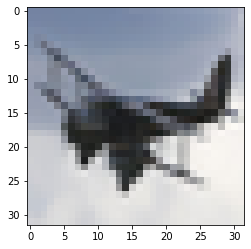

In [24]:
# Example predictions:
def show_img_test(image):
    plt.imshow(image)
    # show the plot
    plt.show()
predictions = model.predict(test_datagen.standardize(x_test.astype(float)));
index = random.randint(1, x_test.shape[0])
print("Image is dead? ", y_test_dead_alive[index])
print("Prediction: ", predictions[index])
show_img_test(x_test[index])